<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Discrete-areas" data-toc-modified-id="Discrete-areas-1">Discrete areas</a></span><ul class="toc-item"><li><span><a href="#Prepare-data" data-toc-modified-id="Prepare-data-1.1">Prepare data</a></span></li><li><span><a href="#Points-to-h3-indexes" data-toc-modified-id="Points-to-h3-indexes-1.2">Points to h3 indexes</a></span></li><li><span><a href="#Choropleth-map" data-toc-modified-id="Choropleth-map-1.3">Choropleth map</a></span></li><li><span><a href="#Interactive-map" data-toc-modified-id="Interactive-map-1.4">Interactive map</a></span></li><li><span><a href="#Points-per-area" data-toc-modified-id="Points-per-area-1.5">Points per area</a></span></li></ul></li><li><span><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-2">Data cleaning</a></span><ul class="toc-item"><li><span><a href="#Noise" data-toc-modified-id="Noise-2.1">Noise</a></span></li><li><span><a href="#Detect-outliers" data-toc-modified-id="Detect-outliers-2.2">Detect outliers</a></span></li><li><span><a href="#Remove-outliers" data-toc-modified-id="Remove-outliers-2.3">Remove outliers</a></span><ul class="toc-item"><li><span><a href="#Discussion" data-toc-modified-id="Discussion-2.3.1">Discussion</a></span></li><li><span><a href="#Algorithm" data-toc-modified-id="Algorithm-2.3.2">Algorithm</a></span></li><li><span><a href="#Removal" data-toc-modified-id="Removal-2.3.3">Removal</a></span></li></ul></li></ul></li></ul></div>

# Discrete areas

Split area into discrete regions.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
from h3 import h3

from pylab import rcParams
rcParams['figure.figsize'] = (10, 7)

import pandas as pd
pd.set_option('max_columns', 40)
pd.set_option('max_rows', 20)
pd.set_option('precision', 3)

## Prepare data

In [51]:
%%time 

data = pd.read_feather('structured_data.feather')

data = data.sample(1000000)

data.head()

CPU times: user 5.42 s, sys: 8 s, total: 13.4 s
Wall time: 19.3 s


,datetime,lon,lat
13189478,2015-02-07 20:05:37,-73.975,40.752
56958522,2015-06-07 00:04:05,-73.984,40.755
60703964,2015-06-17 19:55:01,-73.986,40.759
60777640,2015-06-17 23:11:22,-73.991,40.756
12865004,2015-02-07 00:20:45,-73.959,40.764


## Points to h3 indexes

In [53]:
%%time


def point_h3_indexes(points: pd.DataFrame, res: int) -> np.ndarray:
    """Create h3 indexes for each lat-lon pair in points"""

    h3_indexes = points.apply(
        lambda point: h3.geo_to_h3(point['lat'], point['lon'], res),
        axis=1
    )
    return h3_indexes


data['h3_res8'] = point_h3_indexes(data, 8)
data['h3_res9'] = point_h3_indexes(data, 9)

CPU times: user 1min 1s, sys: 553 ms, total: 1min 2s
Wall time: 1min 3s


## Choropleth map

Count the number of points per area and color hexagons according to the number

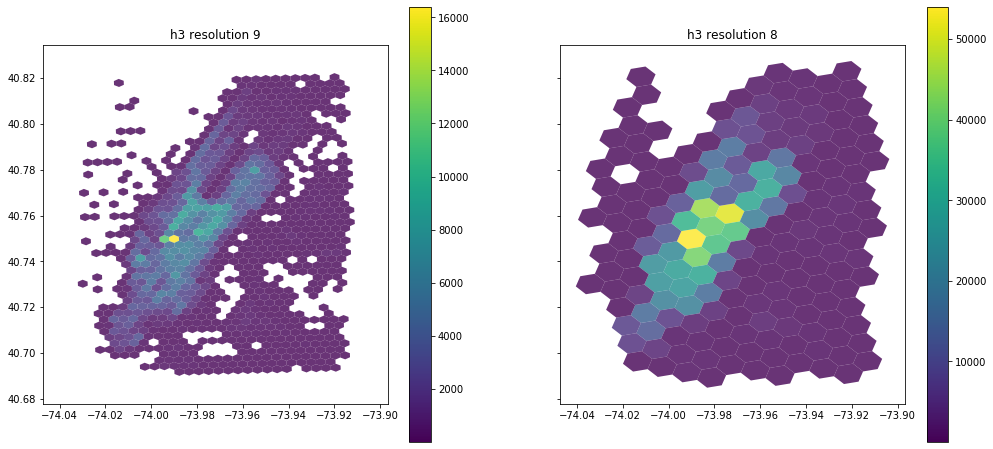

In [539]:
from shapely.geometry import Polygon
import geopandas as gpd


def h3_to_polygon(item) -> Polygon:
    """Convert h3 index to shapely polygon"""
    h3_index = item['index']
    boundary = h3.h3_to_geo_boundary(h3_address=h3_index, geo_json=True)
    return Polygon(boundary)


def plot_choropleth(data, title=None, ax=None):
    counts = data.value_counts()
    counts = counts.to_frame(name='total').reset_index()
    
    geo_df = gpd.GeoDataFrame(counts, geometry=counts.apply(h3_to_polygon, axis=1))
    geo_df.plot(column='total', alpha=0.8, legend=True, ax=ax);
    
    if title and ax:
        ax.set_title(title)
    elif title:
        plt.title(title)
    
fig = plt.figure(figsize=(17, 8))
(ax1, ax2) = fig.subplots(1, 2, sharex=True, sharey=True)

plot_choropleth(data.h3_res9, 'h3 resolution 9', ax=ax1)
plot_choropleth(data.h3_res8, 'h3 resolution 8', ax=ax2);

## Interactive map

Create an interactive map using _folium_ to plot hexagons with different resolutions

In [55]:
import geojson
from geojson import FeatureCollection
import folium


def indexes_to_polygons(h3_indexes):
    polygons = []

    for h in h3_indexes:
        polygon = Polygon(h3.h3_to_geo_boundary(h3_address=h, geo_json=True))
        polygons.append(polygon)

    feature_collection = FeatureCollection(polygons)
    return geojson.dumps(feature_collection)


def create_style_fn(color, opacity=0.1, weight=2):
    """Ugly way to set color of json features"""

    return lambda feature: {
        'fillColor': None,
        'color': color,
        'weight': weight,
        'fillOpacity': opacity
    }


m = folium.Map(location=[40.7536, -73.9811], zoom_start=12)

# resolution 8
feature_collection = indexes_to_polygons(data.h3_res8.unique())
folium.GeoJson(
    feature_collection,
    style_function=create_style_fn('blue', opacity=0.1, weight=2),
).add_to(m)

# resolution 9
feature_collection = indexes_to_polygons(data.h3_res9.unique())
folium.GeoJson(
    feature_collection,
    style_function=create_style_fn('green', opacity=0., weight=1)
).add_to(m)

m

## Points per area

Plot distribution of number of points per each area

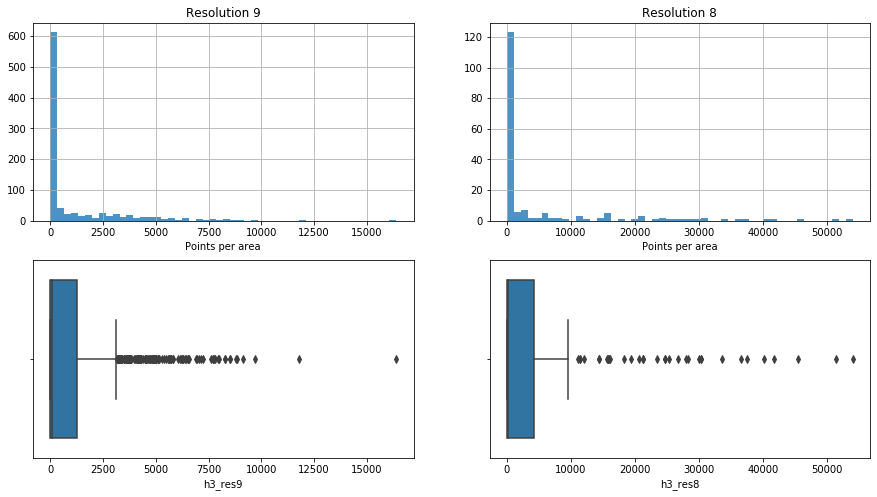

In [107]:
plt.figure(figsize=(15, 8))

plt.subplot(221)
plt.title('Resolution 9')
data.h3_res9.value_counts().hist(bins=50, alpha=0.8);
plt.xlabel('Points per area')

plt.subplot(223)
sns.boxplot(data.h3_res9.value_counts());

plt.subplot(222)
plt.title('Resolution 8')
data.h3_res8.value_counts().hist(bins=50, alpha=0.8);
plt.xlabel('Points per area')

plt.subplot(224)
sns.boxplot(data.h3_res8.value_counts());

Histograms how that the data is largely skewed to the right. It looks noise, let's check basic statistics of the data:

In [215]:
h9_total = data.h3_res9.value_counts().to_frame('total').reset_index()

h9_total.total.describe()

count      931.000
mean      1074.114
std       1956.506
min          1.000
25%          5.500
50%         55.000
75%       1258.500
max      16392.000
Name: total, dtype: float64

# Data cleaning

## Noise

More than half of the areas contain really small number of points. The question is what is _small_ and how to find a cut-off point that separate noise from somehow interesting data - areas where demand prediction makes sense, especially from business point of view (it doesn't make sense to consider areas where the total number of point is, for example, around hundred in 6 month whereas some area contain thousand of points per week).

As simple heuristic is to only consider areas where something happens every day - there are at least one point per day per area for the whole time range of the dataset.

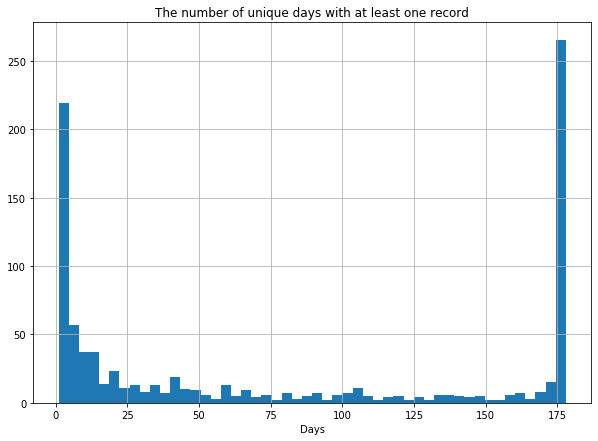

In [323]:
# count number of points per area per day
daily_total = data.groupby(['h3_res9', data.datetime.dt.date]).h3_res9.count()

# convert to dataframe
daily_total = daily_total.to_frame('total').reset_index()

# calculate aggregations
daily_agg = daily_total.groupby('h3_res9').agg(
    {'total': ['sum', 'mean', 'count']})

# plot the number of unique days with at least one record
daily_agg.total['count'].hist(bins=50)

plt.title('The number of unique days with at least one record')
plt.xlabel('Days')

In [328]:
# filter out areas with the number of days with events less than 
# the total number of days
outliers_index = daily_agg.total['count'] < data.datetime.dt.date.nunique()

# list of noisy areas
outliers = daily_agg[outliers_index].index.tolist()

data_clean = data[~data.h3_res9.isin(outliers)]

print('Original dataset:')
print('- size:', data.shape[0])
print('- number of areas', data.h3_res9.nunique())

print('\nClean dataset:')
print('- size:', data_clean.shape[0])
print('- number of areas', data_clean.h3_res9.nunique())

Original dataset:
- size: 1000000
- number of areas 931

Clean dataset:
- size: 915288
- number of areas 242


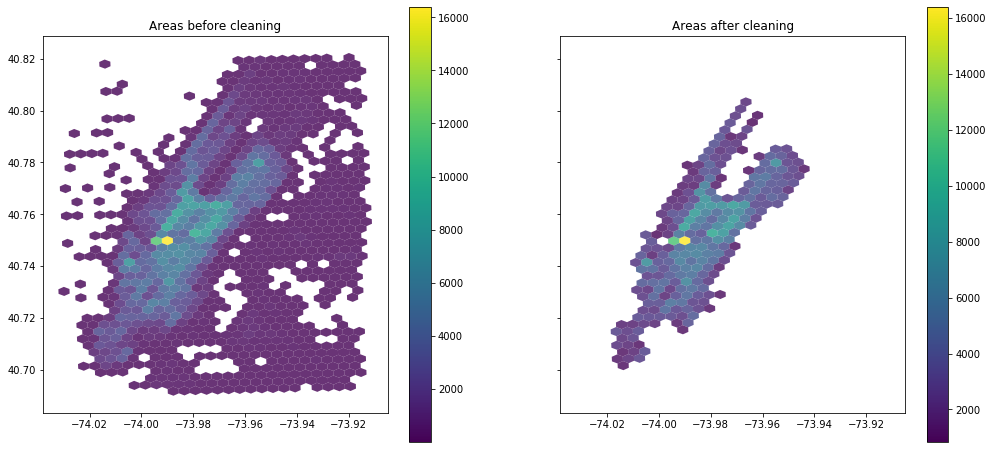

In [540]:
fig = plt.figure(figsize=(17, 8))
(ax1, ax2) = fig.subplots(1, 2, sharex=True, sharey=True)


plot_choropleth(data.h3_res9, 'Areas before cleaning', ax=ax1)
plot_choropleth(data_clean.h3_res9, 'Areas after cleaning', ax=ax2)

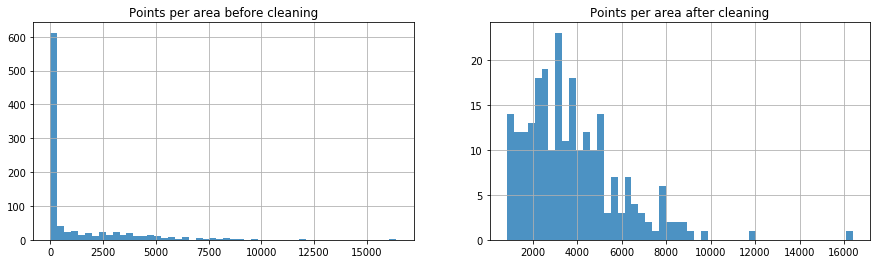

In [318]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.title('Points per area before cleaning')
data.h3_res9.value_counts().hist(bins=50, alpha=0.8);

plt.subplot(122)
plt.title('Points per area after cleaning')
data_clean.h3_res9.value_counts().hist(bins=50, alpha=0.8);

## Detect outliers

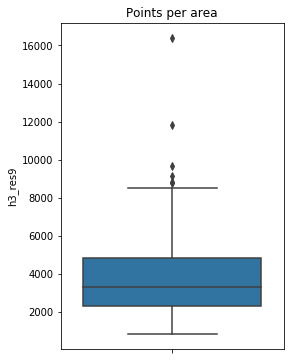

In [338]:
plt.figure(figsize=(4, 6))
sns.boxplot(data_clean.h3_res9.value_counts(), orient='v');

plt.title('Points per area');

There are few areas where the number of points is too high. It could be that:

- there are too many points per day in that areas
- there are some peak days with a large number of point per area

In the second case peak days can be removed from history of areas with high total number of points.

In [361]:
# count number of points per area per day
daily_total = data_clean.groupby(
    ['h3_res9', data.datetime.dt.date]).h3_res9.count()

# convert to dataframe
daily_total = daily_total.to_frame('total').reset_index()

daily_total.sample(5)

,h3_res9,datetime,total
36795,892a1072c03ffff,2015-05-10,8
40652,892a1072ca7ffff,2015-03-12,11
12282,892a100d20fffff,2015-01-01,21
39241,892a1072c83ffff,2015-03-25,18
29569,892a100d6cfffff,2015-01-22,32


Use MAD based method (explained in the exploration notebook) to detect outliers:

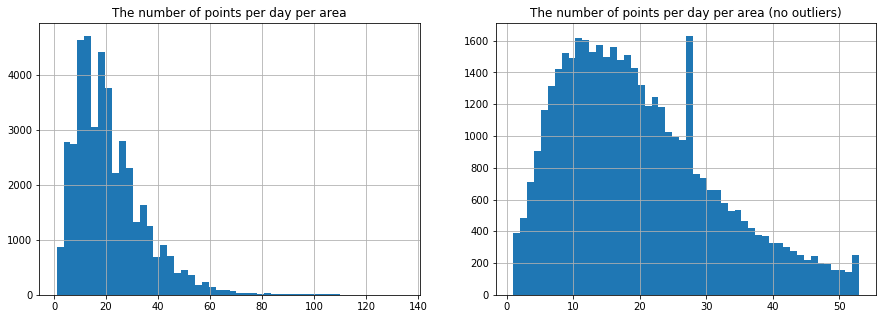

In [398]:
from tools import MAD_outliers

plt.figure(figsize=(15, 5))
plt.subplot(121)

daily_total.total.hist(bins=50);
plt.title('The number of points per day per area');

plt.subplot(122)
index_outliers = MAD_outliers(daily_total.total)
plt.title('The number of points per day per area (no outliers)');
daily_total.total[~index_outliers].hist(bins=50);

Now we can check if there are areas among outliers where the number of points per day for the whole time range is significantly higher than in other areas. To do this I plot the number of days with large number of points per area and show how far it from the maximum number of unique days:

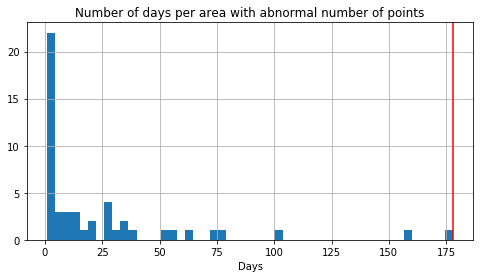

In [403]:
plt.figure(figsize=(8, 4))

daily_total[index_outliers].h3_res9.value_counts().hist(bins=50);

plt.axvline(daily_total.datetime.nunique(), color='r');

plt.title('Number of days per area with abnormal number of points')
plt.xlabel('Days');

There is a least one area with a very high number of points

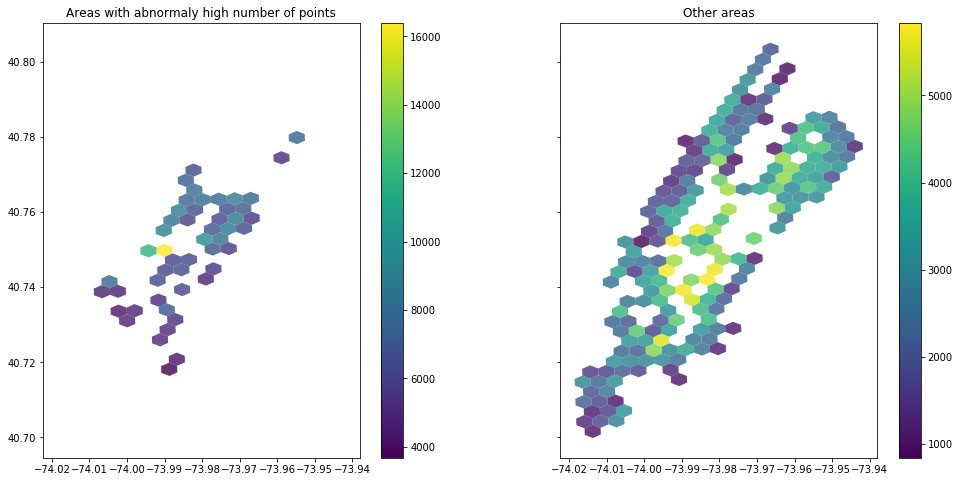

In [541]:
fig = plt.figure(figsize=(17, 8))
(ax1, ax2) = fig.subplots(1, 2, sharex=True, sharey=True)

idx = data_clean.h3_res9.isin(daily_total[index_outliers].h3_res9)

plot_choropleth(data_clean[idx].h3_res9,
                'Areas with abnormaly high number of points', ax=ax1)

plot_choropleth(data_clean[~idx].h3_res9, 'Other areas', ax=ax2)

## Remove outliers

### Discussion
Here we need to make a decision about what to do with outliers. From business point of view, an area with high demand is potentially more profitable. But the data from this area can spoil a demand prediction model.

Common sense suggests that the real anomalies are not the areas with constant high demand but areas where demand increases sporadically. For example, after a football game demand jumped tenfold. This is an abnormal event and if there is no additional data (we don't have a calendar of events from the past) for explaining this, it would be better to remove such records from the dataset.

I would still **keep areas with high constant demand** and decide if I need to remove them on the prediction step. But I would **remove areas with sporadically high demand**.

In [421]:
counts = daily_total[index_outliers].h3_res9.value_counts()

counts.describe()

count     50.000
mean      23.920
std       37.954
min        1.000
25%        2.000
50%        7.500
75%       27.750
max      178.000
Name: h3_res9, dtype: float64

### Algorithm

1. Count the number of points per area per date (per day)
2. Detect outliers using MAD based method
3. Count how many times each area present in the outliers
4. Define two groups of outliers:
    1. Areas with high sporadic increases in the number of points, e.g. 3 times per month
    2. Areas with constantly high number of points, e.g. 28 times per month
5. Define a cut-off point between two groups of outliers
6. Remove areas with high constant demand from outliers
7. Remove outliers from the original dataset

As a cut-off point I will use 75th percentile - everything below are _real_ outliers

### Removal

In [427]:
# Step 1

daily_total = data_clean.groupby(
    ['h3_res9', data.datetime.dt.date]).h3_res9.count()

daily_total = daily_total.to_frame('total').reset_index()

daily_total.sample(5)

,h3_res9,datetime,total
39202,892a1072c83ffff,2015-02-14,22
23031,892a100d60fffff,2015-03-13,39
6877,892a10089abffff,2015-04-26,22
16050,892a100d26fffff,2015-02-02,24
8116,892a1008b17ffff,2015-04-19,7


In [430]:
# Step 2

index_outliers = MAD_outliers(daily_total.total)

daily_total[index_outliers].sample(5)

,h3_res9,datetime,total
23148,892a100d613ffff,2015-01-09,57
19014,892a100d2c3ffff,2015-05-30,106
22481,892a100d603ffff,2015-02-25,56
23243,892a100d613ffff,2015-04-16,63
19387,892a100d2cbffff,2015-06-16,79


In [465]:
# Step 3

outlier_areas = daily_total[index_outliers].h3_res9.value_counts()

outlier_areas.describe()

count     50.000
mean      23.920
std       37.954
min        1.000
25%        2.000
50%        7.500
75%       27.750
max      178.000
Name: h3_res9, dtype: float64

In [466]:
# Step 4
# Step 5

cutoff = np.percentile(outlier_areas.values, 75)

print(f'Cut-off point: {cutoff}')

cutoff_index = outlier_areas < cutoff

Cut-off point: 27.75


In [467]:
# Step 6

print(f'Before: {outlier_areas.shape[0]}')

real_outlier_areas = outlier_areas[cutoff_index].index

print(f'After: {real_outlier_areas.shape[0]}')

num_outliers = index_outliers.sum()
print(f'Original number of outliers: {num_outliers}')

num_outliers = (index_outliers & (daily_total.h3_res9.isin(list(real_outlier_areas)))).sum()
print(f'Filtered number of outliers: {num_outliers}')

Before: 50
After: 37
Original number of outliers: 1196
Filtered number of outliers: 262


In [531]:
%%time

# Step 7

o_idx = index_outliers & (daily_total.h3_res9.isin(list(real_outlier_areas)))
daily_total[o_idx]

outliers_set = set([(i, j) for i, j in daily_total[o_idx]
                    [['h3_res9', 'datetime']].values.tolist()])

r_idx = data_clean.apply(lambda item: (item.h3_res9, pd.to_datetime(
    item.datetime).date()) in outliers_set, axis=1)

print(f'Items to remove {r_idx.sum()}')

Items to remove 15221
CPU times: user 33 s, sys: 363 ms, total: 33.4 s
Wall time: 35.1 s


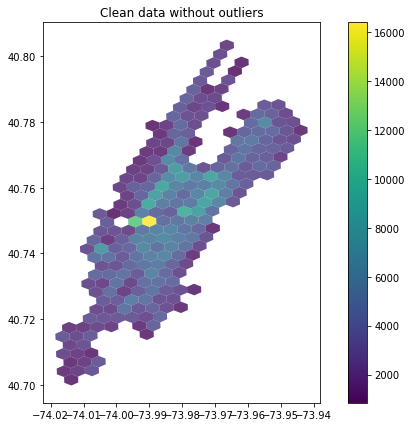

In [542]:
plot_choropleth(data_clean[~r_idx].h3_res9, 'Clean data without outliers')